# SIMULATOR AND SUMMARY STATISTICS

In [6]:
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [19]:
# Load the minimum required library to run the functions
from Utils_functions import *
from numpy.random import uniform
from numpy import array, int64, where, concatenate, linspace, median, sum, log, zeros, mean, var, min, max, einsum
from scipy.integrate import cumulative_trapezoid
from scipy.signal import welch, periodogram
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm
import seaborn as sns
import _pickle as pickle
from InternalLibrary.StatisticalFunctions import *
from astropy import timeseries

In [2]:
dt = 1e-6# The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
Sample_frequency = 25_000 # The sampling frequency. This is the number of samples that are recorded per unit time
DeltaT = 1/Sample_frequency # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
TotalT = 0.5 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent
n_sim = int(10)
t_corr = TotalT/50

In [3]:
time_steps_amount = int64(TotalT/dt) # Number of steps
sampled_point_amount = int64(TotalT/DeltaT) # Number of sampled points
sampling_delta_time_steps = int64(DeltaT/dt) # Number of steps between samples
t = linspace(0., TotalT,sampled_point_amount) # Time array

Chose the time characteristics of the input signal (total time, sample rate, numbero of simulations) and transform them into points info

In [4]:
# Limits for the parameters
prior_limits = [[1.5e4, 4e4],     # mu_x
                [1e4, 140e4],     # mu_y
                [3e-3, 16e-3],    # k_x
                [1.5e-2, 30e-2],  # k_y
                [1e-3, 6e-3],     # k_int
                [2e-2, 20e-2],    # tau
                [0.5, 6],         # eps
                [5.5, 15.5],      # D_x
                [1, 530]]         # D_y

In [6]:
# Get the theta values from the prior in the different shapes
#theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, n_sim)

In [7]:
# Dummy call to force compilation
#theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, 1)
#Simulator_noGPU(0.1,0.1,1, theta)

In [8]:
%%time
#theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, n_sim)
#x_trace, f_trace, y_trace = Simulator_noGPU(dt, DeltaT, TotalT, theta)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


In [9]:
%%time
#list_stat = ["Cxx", "s_redx", "s_redf", "psdx"]
#s = get_summary_statistics(list_stat, x_trace, f_trace, theta, DeltaT, 3, t, t_corr)
#s.shape

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs


In [51]:
# Get the list of files in the directory simulations
files = os.listdir("Simulations/data/")

# Compute and load the summary statistics
for i, file in enumerate(files):
    print('Loading file:', file)
    with open("Simulations/data/" + file, 'rb') as f:
        simulation = pickle.load(f)
    x_trace = simulation['x_trace']
"""    theta_batch = simulation['theta']
    theta_torch_batch = torch.from_numpy(array(theta_batch)[:,:,0].T).to(torch.float32)
    if i == 0:
        theta = theta_torch_batch
    else:
      theta = torch.cat((theta, theta_torch_batch), dim=0)
    
    # Get the summary statistics
    for j in range(len(x_trace)):
        summary_stats = compute_summary_statistics(x_trace[j])
        s_j = select_summary_statistics(summary_stats, ["Cxx", "s_redx", "psdx"])
        if i == 0 and j == 0:
            s = s_j
            print(s.shape)
        else:
            s = torch.cat((s, s_j), dim=0)
print(theta.shape, s.shape)"""

Loading file: 20240504-121214_200sims.pkl


'    theta_batch = simulation[\'theta\']\n    theta_torch_batch = torch.from_numpy(array(theta_batch)[:,:,0].T).to(torch.float32)\n    if i == 0:\n        theta = theta_torch_batch\n    else:\n      theta = torch.cat((theta, theta_torch_batch), dim=0)\n    \n    # Get the summary statistics\n    for j in range(len(x_trace)):\n        summary_stats = compute_summary_statistics(x_trace[j])\n        s_j = select_summary_statistics(summary_stats, ["Cxx", "s_redx", "psdx"])\n        if i == 0 and j == 0:\n            s = s_j\n            print(s.shape)\n        else:\n            s = torch.cat((s, s_j), dim=0)\nprint(theta.shape, s.shape)'

In [52]:
x_trace.shape

(200, 249999)

KeyError: 'hermite4'

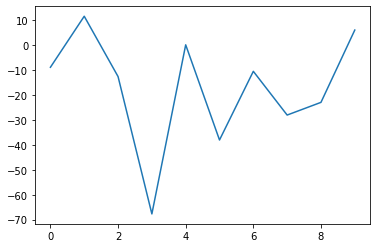

In [34]:
plt.plot(x_trace[-1])
summary_stats = compute_summary_statistics(x_trace[1])
print(summary_stats['hermite4'])

In [17]:
def simulate_ornstein_uhlenbeck(k, D, dt, T):
    """
    Simulate an Ornstein-Uhlenbeck process.
    
    Parameters:
    - theta: the mean-reversion rate
    - mu: the long-term mean
    - sigma: the volatility
    - dt: the time step size
    - T: the total time period
    - x0: the initial value
    
    Returns:
    - x: an array of simulated values
    """
    n_steps = int(T / dt)
    x = np.zeros(n_steps)
    x[0] = 0
    
    for i in range(1, n_steps):
        drift = - k * x[i-1] * dt
        diffusion = np.sqrt(2* D) * np.random.normal(0, dt**2)
        x[i] = x[i-1] + drift + diffusion
    
    return x
x = simulate_ornstein_uhlenbeck(9.5e-3, 10.5, dt, TotalT)

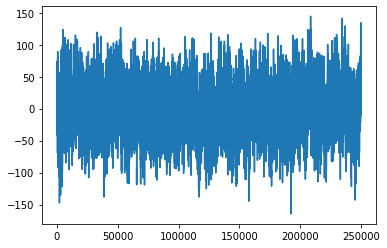

In [53]:
plt.plot(x_trace[0])

In [59]:
x = x_trace[0]
x.shape[0]

249999

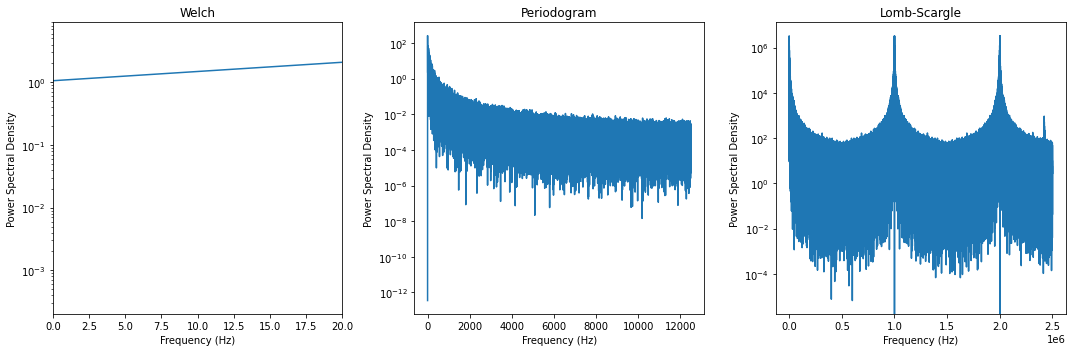

In [69]:
# Calculate the Welch, periodogram, and Lomb-Scargle
fs = 1/DeltaT
t = linspace(0, dt*x.shape[0], x.shape[0])
f_welch, Pxx_welch = welch(x, fs, nperseg=512)
f_periodogram, Pxx_periodogram = periodogram(x, fs)
f_lombscargle, Pxx_lombscargle = timeseries.LombScargle(t, x, normalization='psd', center_data=False).autopower()


# Plot the results side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Welch
axs[0].semilogy(f_welch, Pxx_welch)
axs[0].set_title('Welch')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Power Spectral Density')

# Periodogram
axs[1].semilogy(f_periodogram, Pxx_periodogram)
axs[1].set_title('Periodogram')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Power Spectral Density')

# Lomb-Scargle
axs[2].semilogy(f_lombscargle, Pxx_lombscargle)
axs[2].set_title('Lomb-Scargle')
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('Power Spectral Density')

plt.tight_layout()
plt.show()


In [70]:
Pxx_welch = Pxx_welch[:-2]

In [71]:
mean_psd = np.mean(Pxx_welch)
std_psd = np.std(Pxx_welch)

0.06715691 0.44612765


In [82]:
from scipy.optimize import curve_fit
def corr(x,y,nmax,dt=False):
    '''
    Performs the cross correlation between two single-input signals x and y.

    INPUT
    x: input signal 1
    y: input signal 2
    nmax: maximum number of lags
    dt: time step (default=False)

    OUTPUT
    corr: cross-correlation between x and y
    '''

    assert len(x)==len(y), 'x and y must have the same length'

    n=len(x)
    # pad 0s to 2n-1
    ext_size=2*n-1
    # nearest power of 2
    fsize=2**ceil(log2(ext_size)).astype('int')

    xp=x-mean(x)
    yp=y-mean(y)

    # do fft and ifft
    cfx=fft(xp,fsize)
    cfy=fft(yp,fsize)
    if dt != False:
        freq = fftfreq(n, d=dt)
        idx = where((freq<-1/(2*dt))+(freq>1/(2*dt)))[0]
        
        cfx[idx]=0
        cfy[idx]=0
        
    sf=cfx.conjugate()*cfy
    corr=ifft(sf).real
    corr=corr/n

    return corr[:nmax]
def stat_corr_single(single_x_trace, DeltaT, t, t_corr):
    '''
    Computes the autocorrelation for a single x trace signal.

    INPUT
    singles_x_trace: single x trace signal
    DeltaT: sampling time
    t: time array
    t_corr: maximum time for the correlation

    OUTPUT
    Cxx: autocorrelation x signal
    '''

    sampled_point_amount = single_x_trace.shape[0]
    idx_corr = where((t>0)*(t<t_corr))[0]
    Cxx= corr(single_x_trace, single_x_trace, sampled_point_amount, dt=DeltaT) # compute the autocorrellation for each x trace

    return Cxx


In [87]:
def h(x, index):
    std_x = np.std(x)
    z = x/std_x
    ind = np.zeros(index)
    ind = np.append(ind, 1)
    i = index
    return ((np.exp(-z**2/2)*np.polynomial.hermite.hermval(x, ind)*(2**i*
            np.math.factorial(i)*np.sqrt(np.pi))**-0.5) /np.sqrt(std_x))

def f(t, a0, a2, a4, a6, a8, a10, a12):
    t = t*mean_psd
    return np.sqrt(mean_psd)*(a0*h(t, 0) + a2*h(t, 2) + a4*h(t, 4) + a6*h(t, 6) + a8*h(t, 8) + a10*h(t, 10) + a12*h(t, 12))

Cxx = stat_corr_single(x, DeltaT, t/10, TotalT/50)

popt = curve_fit(f, t, Cxx)
print(popt)

(array([ 1.71116886e+03, -1.60470692e-02,  9.00296834e-08, -4.96171077e-13,
        1.79174016e-18, -3.44668810e-24,  2.77812682e-30]), array([[ 5.40890714e+02, -7.77112575e-03,  6.99540207e-08,
        -3.89133825e-13,  1.33107635e-18, -2.59800334e-24,
         2.23870546e-30],
       [-7.77112575e-03,  2.19088134e-07, -2.38121363e-12,
         1.44852829e-17, -5.21754312e-23,  1.05270353e-28,
        -9.27991695e-35],
       [ 6.99540207e-08, -2.38121363e-12,  2.90674896e-17,
        -1.89315733e-22,  7.12498696e-28, -1.48137169e-33,
         1.33421212e-39],
       [-3.89133825e-13,  1.44852829e-17, -1.89315733e-22,
         1.29621592e-27, -5.05812302e-33,  1.07999496e-38,
        -9.92282067e-45],
       [ 1.33107635e-18, -5.21754312e-23,  7.12498696e-28,
        -5.05812302e-33,  2.03208335e-38, -4.43996083e-44,
         4.15408727e-50],
       [-2.59800334e-24,  1.05270353e-28, -1.48137169e-33,
         1.07999496e-38, -4.43996083e-44,  9.89218182e-50,
        -9.40650091e-56],


In [72]:
def hermite(x, index):
    std_x = np.std(x)
    z = x/std_x
    i = len(index)-1
    return np.mean(((np.exp(-z**2/2)*np.polynomial.hermite.hermval(x, index)*(2**i*
            np.math.factorial(i)*np.sqrt(np.pi))**-0.5) /np.sqrt(std_x)))
def stat_hermite(x):
    '''
    Computes the Hermite statistics for a single trace signal.

    INPUT
    x: single trace signal

    OUTPUT
    s: Hermite statistics
    '''
    s = np.array([])
    zeros = np.zeros(13)
    for i in range(0,13,2):
        for j in range(i+1,13,2):
            index = zeros
            index[j] = 1
            s = np.concatenate((s, [hermite(x, index.tolist())]))
        zeros[i] = 1
    return s

In [80]:
hermite(x, [1,1,0])

0.007457269261152146

In [48]:
print(1/TotalT)
print(f_welch[np.argmax(Pxx_welch)])

2.0
97.65624999999999


In [11]:
#del simulation

s_red = s_red1 + $\alpha$\*s_red2   with $\alpha$ = $(\mu_x k_x)^2$. Since $\mu_x \in [1.5e4, 4e4]$  and $k_x \in [3e-3, 16e-3]$, then $\alpha \in [2e3,4e5]$: problem!! It spans three order of magnitude

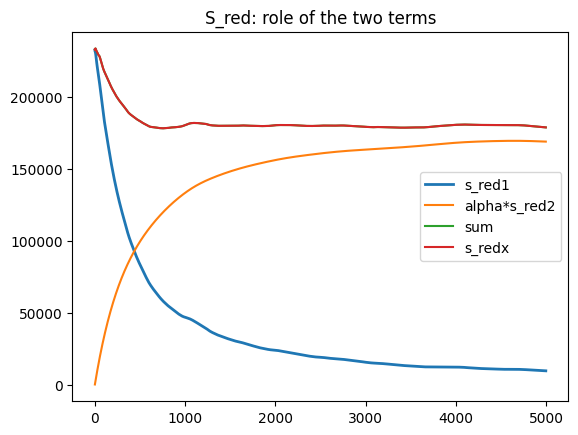

In [19]:
plt.title("S_red: role of the two terms")
#plt.xlim(0, 1000)
plt.plot(summary_stats["s_red1"], label="s_red1", lw=2)
alpha = 1e4
plt.plot(summary_stats["s_red2"], label="alpha*s_red2")
plt.plot(summary_stats["s_red1"] + summary_stats["s_red2"], label="sum")
plt.plot(summary_stats["s_redx"], label="s_redx")
plt.legend()

In [13]:
theta_torch = theta.to(torch.float32)
s = s.to(torch.float32)
theta_torch.shape

torch.Size([800, 9])

Maybe we can select different summary statistics and usa some feature selection technique. If we use a lot of summary statistics maybe dimentionality reductions? PCA?
The idea is to use different summary statistics but to then to select the most important features of them deleting the correllations between them.

An example could be the Power spectral density for both x and f.
It can identify if there are any dominant frequencies in your data, or if the power is distributed across a range of frequencies, usefull for oscillatory behaviour

We can use directly the psds as input of the neural network or we can take some statistics about each one, like mean, median, max, min,variance, entropy, frequency of top power. We can think of more statistics

# INFERENCE STATISTICS

In [14]:
from torch import Tensor, Size
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from numpy import squeeze

In [15]:
prior_limits_array = array(prior_limits)
prior_box = utils.torchutils.BoxUniform(low=torch.tensor(prior_limits_array[:, 0]), high=torch.tensor(prior_limits_array[:, 1]))

In [16]:
# Prior distribution for sbi
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)

In [17]:
# Call infer form sbi
infer = SNPE(prior=prior)
inferece = infer.append_simulations(theta_torch, s)

In [18]:
# Train the model
density_estimator = infer.train()
posterior = infer.build_posterior(density_estimator)

 Neural network successfully converged after 61 epochs.

In [31]:
# Simulate the observation(s)
#theta_true, theta_torch_true, prior_box_true = get_theta_from_prior(prior_limits, n_sim=1)
#x_trace_true, f_trace_true, y_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, 1, theta_true)

In [34]:
# Test simulation (huge bias, but it is just for testing)
with open('Simulations/20240504/20240504-112238_200sims.pkl', 'rb') as f:
    simulations = pickle.load(f)
x_trace_true = simulations['x_trace']
theta_true = simulations['theta']
theta_true = torch.from_numpy(array(theta_true)[:,:,0].T).to(torch.float32)

In [35]:
# Select only what one simul
theta_true = theta_true[2]
x_trace_true = x_trace_true[2]

In [36]:
# Test simulation (huge bias, but it is just for testing)
# Get the summary statistics
summary_stats = compute_summary_statistics(x_trace_true)
s_j = select_summary_statistics(summary_stats, ["Cxx", "s_redx", "psdx"])
s_j = s_j.to(torch.float32)
s_j.shape

torch.Size([1, 10499])

In [37]:
# Sample from the posterior
samples = posterior.sample((int(1e5),), x=s_j)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [22]:
# Sample from the posterior
#s = compute_summary_statistics(list_stat, x_trace_true, f_trace_true, theta_true, DeltaT, 3, t, t_corr)
#samples = posterior.sample((int(1e5),), x=s)

In [20]:
# Function to test, when ready move to Utils_functions.py
def get_centroids_from_samples(samples):
    mean_params = np.array([])
    mode_params = np.array([])

    for i in range(9):
        # Retrive the samples for the parameter i
        params = samples[:,i].numpy()
        # Compute the mean
        mean_params = np.concatenate((mean_params, [np.mean(params)]))
        # Compute the mode
        hist, bin_edges = np.histogram(params, bins=int(np.sqrt(params.shape[0])))
        max_index = np.argmax(hist)
        mode = (bin_edges[max_index] + bin_edges[max_index+1])/2
        mode_params = np.concatenate((mode_params, [mode]))

    mean_params = mean_params.reshape(9, 1, 1)
    mode_params = mode_params.reshape(9, 1, 1)
    return mean_params, mode_params

In [21]:
# Get the centroids of the sample
mean_params, mode_params = get_centroids_from_samples(samples)

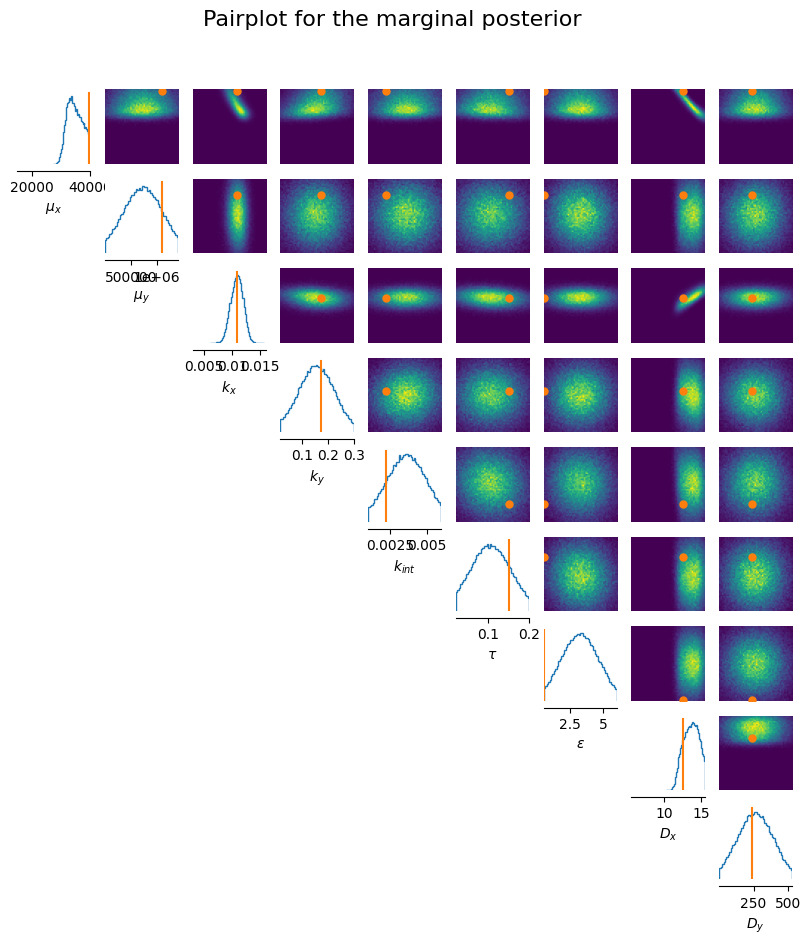

In [38]:
# Pairplot
label_theta = [r"$\mu_x$", r"$\mu_y$", r"$k_x$", r"$k_y$", r"$k_{int}$", r"$\tau$", r"$\varepsilon$", r"$D_x$", r"$D_y$"]
import matplotlib as mpl
_ = analysis.pairplot(samples, points=[theta_true], 
                      limits=prior_limits, figsize=(10, 10), 
                      title = "Pairplot for the marginal posterior",
                      labels=label_theta)

# ENTROPY PRODUCTION

These are the formulas used to compute the entropy production
$$
S = \sum_{t=0}^{N_{\text{timesteps}}-2} \left( \text{data}_{t+1} - \text{data}_{t} \right) \cdot F\left( \frac{\text{data}_{t+1} + \text{data}_{t}}{2} \right) \cdot D^{-1}\left( \frac{\text{data}_{t+1} + \text{data}_{t}}{2} \right)
$$
$$
\sigma = \frac{{\mu_y \cdot \varepsilon^2}}{{1 + k_y \cdot \mu_y \cdot \tau - \frac{{k_{int}^2 \cdot \mu_x \cdot \mu_y \cdot \tau^2}}{{1 + k_x \cdot \mu_x \cdot \tau}}}}
$$

### Analytical entropy

Firstly, let's try looking at the distribution of sigma obtained just sampling the parameters from the prior (i.e. the distribution of "true sigma")

In [23]:
# Simply generating thetas from the prior and computing the entropy
n = int(1e5)
sigmas_from_prior = []

for i in range(n):
    theta, _, _ = get_theta_from_prior(prior_limits, 1)
    sigma = compute_entropy_2(theta, 1)[0][0][0]
    sigmas_from_prior.append(sigma)

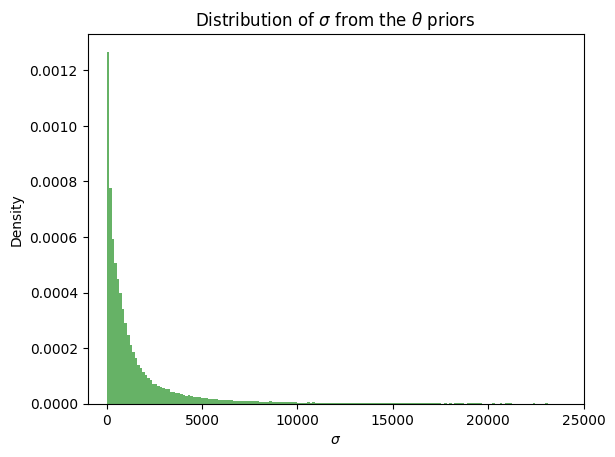

In [24]:
plt.title(r"Distribution of $\sigma$ from the $\theta$ priors")
plt.xlabel(r"$\sigma$")
plt.ylabel("Density")
plt.hist(sigmas_from_prior, bins=1000, density=True, alpha=0.6, color='g')
plt.xlim([-1e3, 25e3])
plt.show();

Let's try to compare the analytical entropy production directly looking at the best estimates of the inferred parameters. 

In [25]:
# Test analytical entropy production on single realization
sigma_true_2, _, = compute_entropy_2(theta_true, 1)
sigma_est_2_mean, _, = compute_entropy_2(mean_params, 1)
sigma_est_2_mode, _, = compute_entropy_2(mode_params, 1)
print("Estimates for the analytical entropy production:")
print(f"True: %.2f, Mean: %.2f, Mode: %.2f" % (sigma_true_2[0][0], sigma_est_2_mean[0][0], sigma_est_2_mode[0][0]))

Estimates for the analytical entropy production:
True: 1216.04, Mean: 733.01, Mode: 727.60


Let's make some statistics out of it. In the following, we'll use multiple indipendent test sets of theta. For each of them, we'll sample the posterior multiple time to get a distribution of the estimated inferred theta. From them, we compute sigma. The net result is a statistics of the inferred sigma (based on the mode of the marginal distributions) over multiple tests. 

In [26]:
# Function to test: when ready, move to Utils_functions.py
def comparison_sigma_analytical(n_test, n_sim_obs, 
                                prior_limits=prior_limits, list_stat=list_stat, t_corr=t_corr, t=t, DeltaT=DeltaT, dt=dt):
    sigma_true_array = np.zeros((n_test, 1))
    sigma_est_array = np.zeros((n_test, n_sim_obs))

    for i in range(n_test):
        # Get the true parameters and the n_sim_obs traces
        theta_true, _, _ = get_theta_from_prior(prior_limits, n_sim=n_sim_obs)
        x_trace_true, f_trace_true, _ = Simulator_noGPU(dt, DeltaT, TotalT, n_sim_obs, theta_true)
            
        # Compute the (true) entropy production analytically
        sigma_true, _, = compute_entropy_2(theta_true, 1)
        sigma_true_array[i] = sigma_true[0][0]

        # Get the summary statistics
        s = get_summary_statistics(list_stat, x_trace_true, f_trace_true, theta_true, DeltaT, 3, t, t_corr)

        for j in range(n_sim_obs):
            # Sample from the posterior
            samples = posterior.sample((int(1e5),), x=s[j, :], show_progress_bars=False)

            # Get the mean and mode parameters
            mean_params, mode_params = get_centroids_from_samples(samples)

            # Compute the entropy production analytically
            sigma_est_mode, _, = compute_entropy_2(mode_params, 1)
            sigma_est_array[i, j] = sigma_est_mode[0][0]    
    
    return sigma_true_array, sigma_est_array

In [27]:
%%time
# Test on analytical entropy production on multiple realizations
n_test = 2  # Number of test realizations
n_sim_obs = 5  # Number of observed trace per realization

sigma_true_array, sigma_est_array = comparison_sigma_analytical(n_test, n_sim_obs)

CPU times: user 39min 57s, sys: 18min 39s, total: 58min 36s
Wall time: 14min 42s


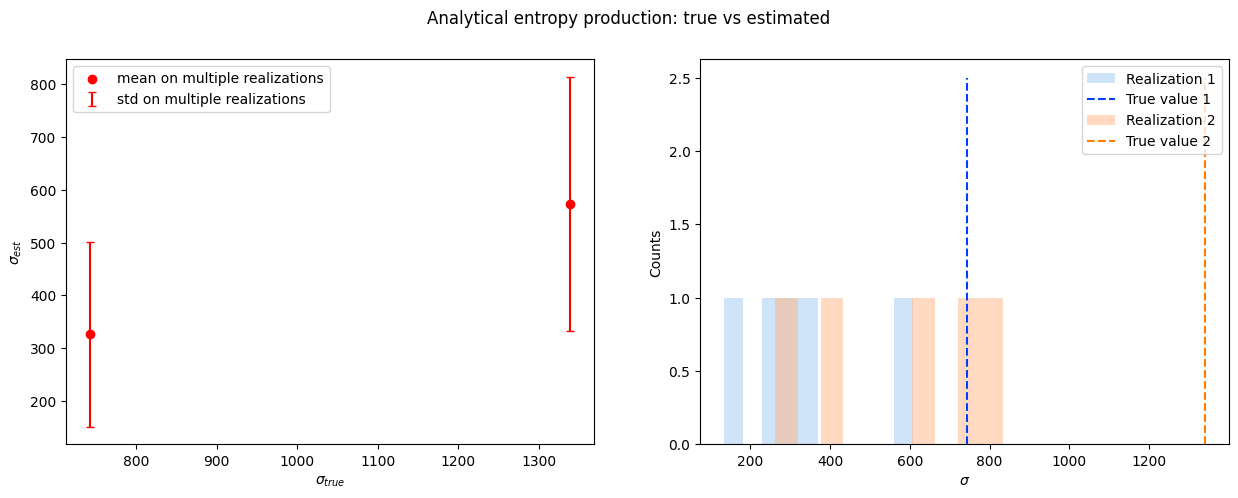

In [28]:
plt.figure(figsize=(15, 5))
plt.suptitle("Analytical entropy production: true vs estimated")

plt.subplot(121)
plt.xlabel(r"$\sigma_{true}$")
plt.ylabel(r"$\sigma_{est}$")
plt.scatter(sigma_true_array, np.mean(sigma_est_array, axis=1), label='mean on multiple realizations', color='red')
plt.errorbar(sigma_true_array, np.mean(sigma_est_array, axis=1), yerr=np.std(sigma_est_array, axis=1, ddof=1), 
             fmt=' ', capsize=3, label='std on multiple realizations', color='red')
#plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.legend()

plt.subplot(122)
color_palette_1 = sns.color_palette("pastel", n_test)
color_palette_2 = sns.color_palette("bright", n_test)

for i in range(n_test):
    plt.hist(sigma_est_array[i, :], alpha=0.5, label=f"Realization {i+1}", color=color_palette_1[i])
    plt.vlines(sigma_true_array[i], 0, n_sim_obs/n_test, color=color_palette_2[i], linestyle='--', label=f'True value {i+1}')
plt.xlabel(r"$\sigma$")
plt.ylabel("Counts")

plt.legend();

Now let's try a different approach. Instead of looking at the best estimates for the parameters, we'll use the entire posterior (of a single realization) to build a distribution of sigma.

In [29]:
# Obtain the samples from the posterior of a single realization
theta_true, theta_torch_true, prior_box_true = get_theta_from_prior(prior_limits, 1)
x_trace_true, f_trace_true, y_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, 1, theta_true)
s = get_summary_statistics(list_stat, x_trace_true, f_trace_true, theta_true, DeltaT, 3, t, t_corr)

samples = posterior.sample((int(1e5),), x=s)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [30]:
# Get the true entropy production
sigma_true_2 = compute_entropy_2(theta_true, 1)[0][0][0]

# Get the statistics of sigma directly out of the samples
sigma_samples = array([])
#sanity_check = array([])

for i in range(samples.shape[0]):
    sample = samples[i,:].numpy().reshape(9,1,1)
    #sanity_check = concatenate((sanity_check, [sample[0][0][0]]))
    sigma = compute_entropy_2(list(sample), 1)[0][0][0]
    sigma_samples = concatenate((sigma_samples, [sigma]))

True value: 1370.39


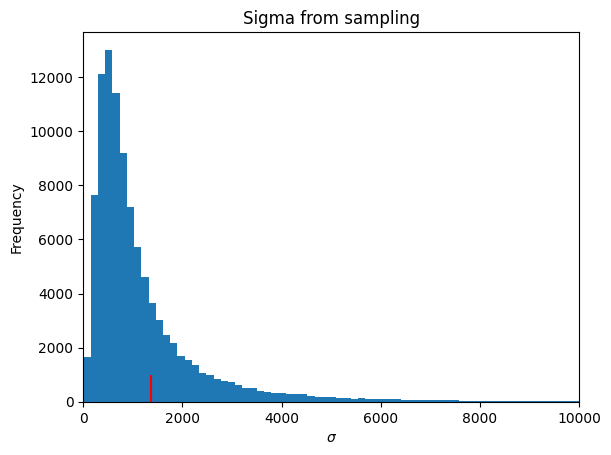

In [31]:
plt.xlim(0, 1e4)
plt.vlines(sigma_true_2, 0, 1e3, color='r')
print("True value: %.2f" % sigma_true_2)
plt.xlabel(r"$\sigma$")
plt.ylabel("Frequency")
plt.title("Sigma from sampling")
plt.hist(sigma_samples, bins=int(np.sqrt(len(sigma_samples))));

TO DO (when we'll have decent results): do the same but with multiple tests

### Experimental entropy

Fistly, let's look at the experimental entropy distribution obtain simply generating samples from the prior.

In [17]:
# %%time
# # Compute the obtained entropy production individually for each simulation
# n_sim = int(1e3)
# emp_sigma_from_prior = []

# # Save also the analytical entropy production (for later comparison)
# sigma_from_prior = []

# ## This approach is computationally suboptimal, but compute_entropy_production is peaky and I don't want to change it now
# for i in tqdm(range(n_sim)):
#     # Simulate the dynamics
#     theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, 1)
#     x_trace, f_trace, y_trace = Simulator_noGPU(dt, DeltaT, TotalT, 1, theta)

#     # Compute the entropy production
#     emp_sigma, _, _, _ = compute_entropy_production(x_trace, y_trace, f_trace, theta, 1)
#     emp_sigma_from_prior.append(emp_sigma)

#     # Compute the analytical entropy production
#     sigma = compute_entropy_2(theta, 1)[0]
#     sigma_from_prior.append(sigma)

In [11]:
%%time
# Compute the obtained entropy production priors, individually for each simulation
emp_sigma_from_prior = np.array([])
sigma_from_prior = np.array([])

n_sim = int(1e4)
n_batch = int(1e2)

print("Computing %d simulations in %d batches" % (n_batch*(n_sim//n_batch), n_sim//n_batch))
for i in tqdm(range(n_sim//n_batch)):
    # Simulate the dynamics
    theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, n_batch)
    x_trace, f_trace, y_trace = Simulator_noGPU(dt, DeltaT, TotalT, n_batch, theta)

    # Compute the empirical entropy production
    _, _, _, emp_sigma_vec = compute_entropy_production(x_trace, y_trace, f_trace, theta, n_batch)
    emp_sigma_from_prior = np.concatenate((emp_sigma_from_prior, emp_sigma_vec))

    # Compute the analytical entropy production
    sigma_vec, _ = compute_entropy_2(theta, n_batch)
    sigma_from_prior = np.concatenate((sigma_from_prior, sigma_vec))

    # Clear the memory (for safety)
    #del theta, theta_torch, prior_box, x_trace, f_trace, y_trace
    #del emp_sigma_vec, sigma_vec

Computing 10000 simulations in 100 batches


100%|██████████| 100/100 [1:25:47<00:00, 51.47s/it]

CPU times: user 1h 25min 50s, sys: 28.5 s, total: 1h 26min 18s
Wall time: 1h 25min 47s


In [5]:
action = "load"

if action == "save":
    with open("data/sigma_from_prior.pkl", 'wb') as f:
        pickle.dump(sigma_from_prior, f)

    with open("data/emp_sigma_from_prior.pkl", 'wb') as f:
        pickle.dump(emp_sigma_from_prior, f)

if action == "load":
    with open("data/sigma_from_prior.pkl", 'rb') as f:
        sigma_from_prior = pickle.load(f)

    with open("data/emp_sigma_from_prior.pkl", 'rb') as f:
        emp_sigma_from_prior = pickle.load(f)

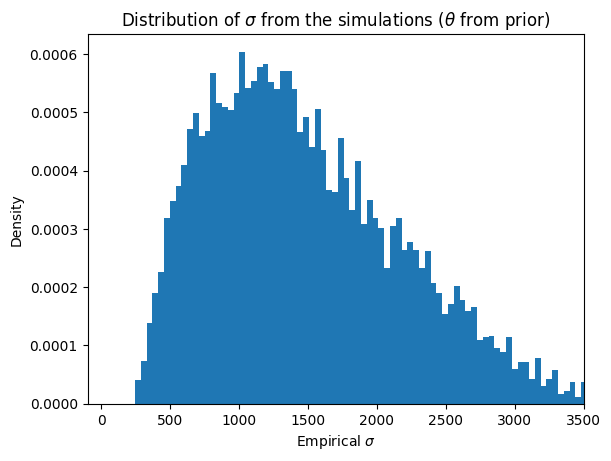

In [6]:
plt.hist(emp_sigma_from_prior, bins=int(1e3), density=True)
plt.xlim(-100, 3500)
plt.xlabel(r"Empirical $\sigma$")
plt.ylabel("Density")
plt.title(r"Distribution of $\sigma$ from the simulations ($\theta$ from prior)");

Let's compare the empirical and analytical sigma

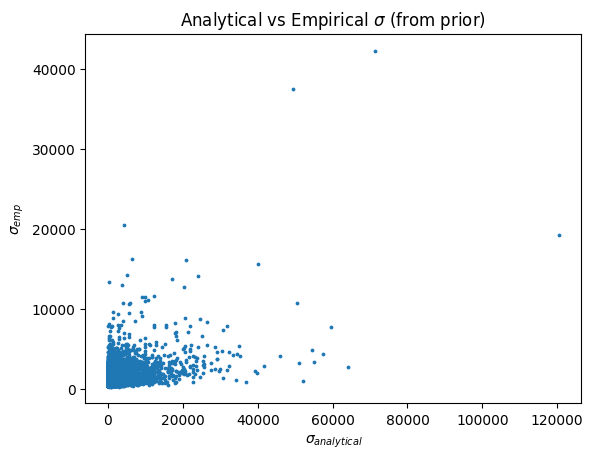

In [7]:
plt.scatter(sigma_from_prior, emp_sigma_from_prior, s=3)
plt.xlabel(r"$\sigma_{analytical}$")
plt.ylabel(r"$\sigma_{emp}$")
plt.title("Analytical vs Empirical $\sigma$ (from prior)");

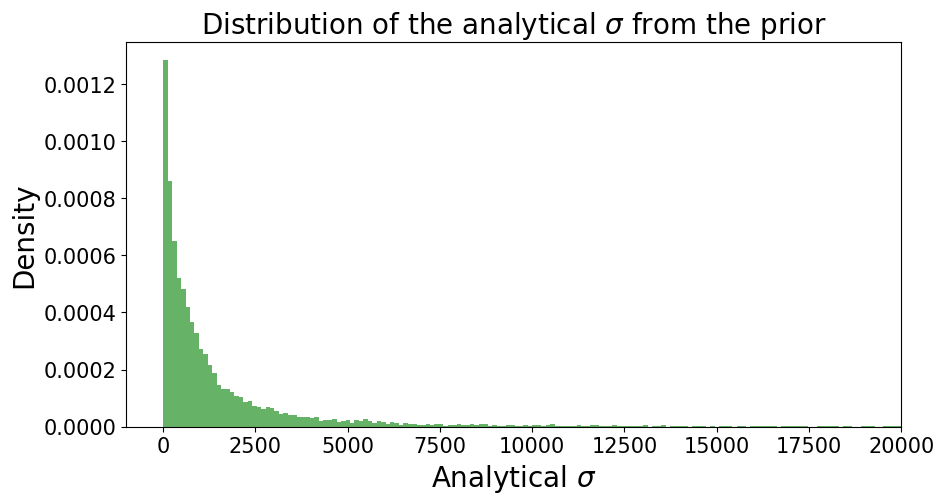

In [15]:
plt.figure(figsize=(10, 5))
plt.title("Distribution of the analytical $\sigma$ from the prior", fontsize=20)
plt.xlabel(r"Analytical $\sigma$", fontsize=20)
plt.ylabel("Density", fontsize=20)
plt.hist(sigma_from_prior, bins=int(1e3), density=True, alpha=0.6, color='g')
plt.xlim(-1000, 20000)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show();


Now let's look at the distribution of the empirical sigma for fixed parameters

In [35]:
# %%time
# n_test = int(2e2)
# emp_sigma_fixed_theta = []

# # Sample the prior (once!)
# theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, 1)

# # Obtain the entropy production for different simulations
# for i in tqdm(range(n_test)):
#     x_trace, f_trace, y_trace = Simulator_noGPU(dt, DeltaT, TotalT, 1, theta)
#     emp_sigma, _, _, _ = compute_entropy_production(x_trace, y_trace, f_trace, theta, 1)
#     emp_sigma_fixed_theta.append(emp_sigma)

100%|██████████| 200/200 [01:30<00:00,  2.21it/s]

CPU times: user 1min 30s, sys: 215 ms, total: 1min 31s
Wall time: 1min 30s


In [13]:
%%time
n_test = int(1e2)  # Number of independent tests
n_trial = int(1e2)  # Number of runs for each set of parameters

emp_sigma_fixed_theta = np.zeros((n_test, n_trial))

for i in tqdm(range(n_test)):
    # Sample the prior (once!)
    theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, 1)
    theta_tile = np.tile(theta, (n_trial, 1))

    # Obtain the entropy production for different simulations
    x_trace, f_trace, y_trace = Simulator_noGPU(dt, DeltaT, 5, n_trial, theta_tile)
    _, _, _, emp_sigma_vec = compute_entropy_production(x_trace, y_trace, f_trace, theta_tile, n_trial)
    emp_sigma_fixed_theta[i, :] = emp_sigma_vec

100%|██████████| 100/100 [1:28:48<00:00, 53.29s/it]

CPU times: user 1h 28min 49s, sys: 31.1 s, total: 1h 29min 20s
Wall time: 1h 28min 48s


In [11]:
# Save the data
action = "load"

if action == "save":
    with open("data/emp_sigma_fixed_theta.pkl", 'wb') as f:
        pickle.dump(emp_sigma_fixed_theta, f)

if action == "load":
    with open("data/emp_sigma_fixed_theta.pkl", 'rb') as f:
        emp_sigma_fixed_theta = pickle.load(f)

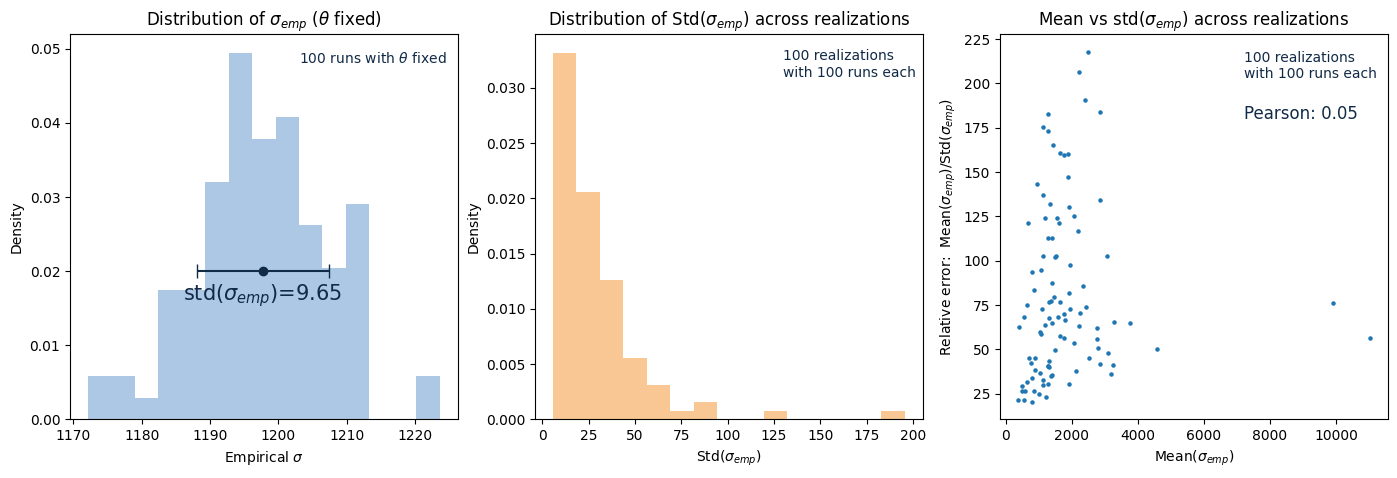

In [25]:
plt.figure(figsize=(17, 5))

plt.subplot(131)
plt.hist(emp_sigma_fixed_theta[9, :], bins=15, density=True, color='#ACC8E5')
plt.xlabel(r"Empirical $\sigma$")
plt.ylabel("Density")
plt.title(r"Distribution of $\sigma_{emp}$ ($\theta$ fixed)")
m = np.mean(emp_sigma_fixed_theta[9, :])
s = np.std(emp_sigma_fixed_theta[9, :])
plt.errorbar(m, 0.02, xerr=s, fmt='o', color='#112A46', capsize=5)
plt.text(1186, 0.016, r"std($\sigma_{emp}$)=%.2f" % s, color='#112A46', fontsize=15)
plt.text(1203, 0.048, r"%d runs with $\theta$ fixed" % emp_sigma_fixed_theta.shape[1], 
         color='#112A46', fontsize=10)

plt.subplot(132)
plt.hist(np.std(emp_sigma_fixed_theta, axis=1), bins=15, density=True, color="#F8C794")
plt.xlabel(r"Std($\sigma_{emp}$)")
plt.ylabel("Density")
plt.title(r"Distribution of Std($\sigma_{emp}$) across realizations")
plt.text(130, 0.031, 
         f"%d realizations \n" % emp_sigma_fixed_theta.shape[0] + "with %d runs each" % emp_sigma_fixed_theta.shape[1], 
         color='#112A46', fontsize=10)

plt.subplot(133)
plt.scatter(np.mean(emp_sigma_fixed_theta, axis=1), 
            np.mean(emp_sigma_fixed_theta, axis=1)/np.std(emp_sigma_fixed_theta, axis=1), s=5)
plt.xlabel(r"Mean($\sigma_{emp}$)")
plt.ylabel(r"Relative error:  Mean($\sigma_{emp}$)/Std($\sigma_{emp}$)")
plt.title(r"Mean vs std($\sigma_{emp}$) across realizations")
plt.text(7200, 203, 
         f"%d realizations \n" % emp_sigma_fixed_theta.shape[0] + "with %d runs each" % emp_sigma_fixed_theta.shape[1], 
         color='#112A46', fontsize=10);
r = np.corrcoef(np.mean(emp_sigma_fixed_theta, axis=1), np.mean(emp_sigma_fixed_theta, axis=1)/np.std(emp_sigma_fixed_theta, axis=1))[0, 1]
plt.text(7200, 180, "Pearson: %.2f" % r, color='#112A46', fontsize=12);

Now let's introduce SBI and the posterior. Firstly, let's sample from a single realization of the sbi and simulate the dynamics (once for computational reasons) to compute the corresponding empirical sigma

In [37]:
%%time
# Get the true parameters (single realization)
theta_true, theta_torch_true, prior_box_true = get_theta_from_prior(prior_limits, 1)
x_trace_true, f_trace_true, y_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, 1, theta_true)

true_sigma_emp = compute_entropy_production(x_trace_true, y_trace_true, f_trace_true, theta_true, 1)[0]

# Sample from the posterior (few points due to later computational cost)
s = get_summary_statistics(list_stat, x_trace_true, f_trace_true, theta_true, DeltaT, 3, t, t_corr)
samples = posterior.sample((int(2e2),), x=s, show_progress_bars=False)

# Compute for each sample the entropy production
emp_sigma_samples = array([])
for i in tqdm(range(samples.shape[0])):
    sample = samples[i,:].numpy().reshape(9,1,1)
    x_trace, f_trace, y_trace = Simulator_noGPU(dt, DeltaT, TotalT, 1, list(sample))
    emp_sigma, _, _, _ = compute_entropy_production(x_trace, y_trace, f_trace, list(sample), 1)
    emp_sigma_samples = concatenate((emp_sigma_samples, [emp_sigma]))

100%|██████████| 200/200 [01:33<00:00,  2.14it/s]

CPU times: user 1min 34s, sys: 270 ms, total: 1min 35s
Wall time: 1min 34s


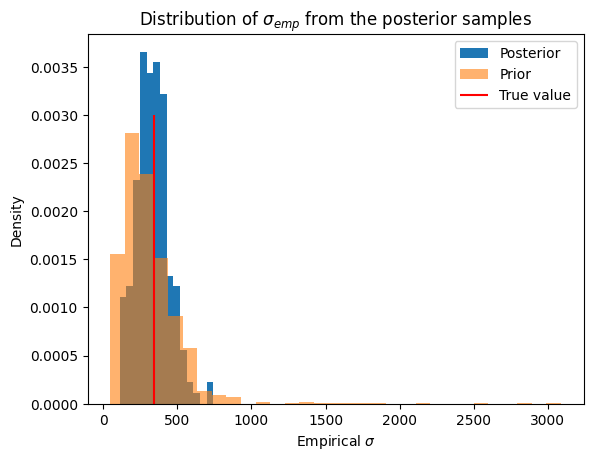

In [46]:
plt.title(r"Distribution of $\sigma_{emp}$ from the posterior samples")
plt.hist(emp_sigma_samples, bins=int(np.sqrt(len(emp_sigma_samples))), density=True, label='Posterior')
plt.hist(emp_sigma_from_prior, bins=int(np.sqrt(len(emp_sigma_from_prior))), density=True, label='Prior', alpha=0.6)
plt.vlines(true_sigma_emp, 0, 0.003, color='r', label='True value')
plt.xlabel(r"Empirical $\sigma$")
plt.ylabel("Density")
plt.legend();

# QUESTIONS
- per calcolare S_red come summary statistics (come fatto da Dresda nel file) usiamo i parametri, non è un bias poi usarla come summary statistics nel neural network durante la SBI?
- qual è la formula corretta per l'entropia? Cosa abbiamo usato noi?
- limiti per la prior distribution sui parametri